In [1]:
import torch
import einops
import numpy as np
import matplotlib.pyplot as plt

from paperlab.zoo import vit
from paperlab.core import Config
from torch.utils.data import Subset, DataLoader

import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [2]:
params = {
    'image_size': (32, 32),
    'patch_size': (8, 8),
    'num_channel': 3,
    'pool': 'cls',
    'num_class': 10,

    'transformer.depth': 2,
    'transformer.dim': 64,
    'transformer.dropout': 0.1,
    'transformer.emb_dropout': 0.,
    'transformer.num_head': 2,
    'transformer.dim_head': 32,
    'transformer.dim_mlp': 32,

    'learning.batch_size': 16,
    'learning.lr': 1e-3,
    'learning.num_epoch': 1,
    'learning.early_stop_patience': 5,
}

config = Config(**params)

In [3]:
model = vit.train(config)

number of model parameter: 56074
Files already downloaded and verified
Files already downloaded and verified
step-1000 training_loss: 1.9267
step-2000 training_loss: 1.7468
step-3000 training_loss: 1.6545
step-3125: dev_loss: 1.7392, dev_acc: 0.3723


In [4]:
def scale(attn):
    return (attn - attn.min()) / (attn.max() -  attn.min())

Files already downloaded and verified
Files already downloaded and verified


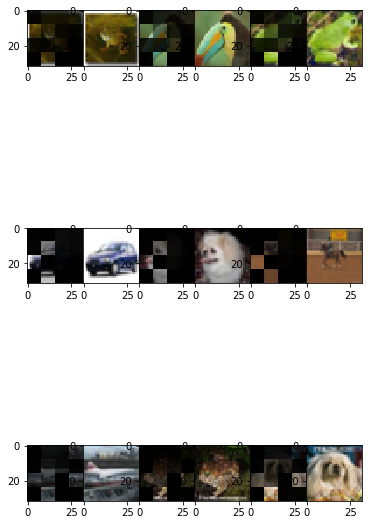

In [5]:
num_row, num_col = 3, 3

_, dev_dataset = vit.get_data()
# random sample `num_row * num_col` images from the devset 
sample_indices = np.random.permutation(np.arange(len(dev_dataset)))[: num_row * num_col]
sampled_subset = Subset(dev_dataset, sample_indices)

# feed the sampled images and get its attention maps
attn_maps, images = vit.get_attention_maps(model, 
                                           DataLoader(sampled_subset, batch_size=config.learning.batch_size))

f, ax = plt.subplots(num_row, num_col * 2, 
                     figsize=(num_row * 2, num_col * 4),
                     gridspec_kw={'wspace':0, 'hspace':0}, 
                     squeeze=True)

for i in range(num_row):
    for j in range(num_col):
        attn_map, image = attn_maps[i * num_col], images[i * num_col + j]
        attend_image = scale(torch.unsqueeze(attn_map, 0)) * image
        
        ax[i, 2 * j].imshow(einops.rearrange(attend_image, 'c h w -> h w c'))  # show image masked with attention
        ax[i, 2 * j + 1].imshow(einops.rearrange(image, 'c h w -> h w c'))  # show original image

In [6]:
N = 128
sample_indices = np.random.permutation(np.arange(len(dev_dataset)))[: N]
sampled_subset = Subset(dev_dataset, sample_indices)

attn_distance = vit.get_attention_distance(model, 
                                           DataLoader(sampled_subset, batch_size=config.learning.batch_size))

for head in range(config.transformer.num_head):
    dist_by_layer = attn_distance[:, head]
    plt.scatter(range(config.transformer.depth), dist_by_layer, label=f"head {head}")

plt.legend()
plt.xlabel('layer')
plt.ylabel('mean attention distance (pixels)')